In [ ]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# checkout specific branch if needed
!cd mode_connectivity; git checkout main

In [1]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity")

from mode_connectivity.utils import experiments, weight_matching, utils, data, training, plot
import torch
from torchvision import transforms
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Experiment 1: MNIST LMC

In [2]:
experiment_config = experiments.MLP_MNIST_DEFAULT
experiment_config.epochs = 10
experiment_config.seed = 7
model_a,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval = experiments.setup_experiment(experiment_config)
experiments.run_simple_experiment(model_a,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval, verbose=1)

# Change seed to get different model
experiment_config.seed = 42
model_b,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval = experiments.setup_experiment(experiment_config)
experiments.run_simple_experiment(model_b,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval, verbose=1)

/Users/tlong/Documents/code/mode_connectivity/models/mlp.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)


Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1301, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0951, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0729, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (99%) 
Average loss: 0.0801, Accuracy: (98%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0891, Accuracy: (97%)
Train Epoch: 6, Train Accuracy: (99%) 
Average loss: 0.0813, Accuracy: (98%)
Train Epoch: 7, Train Accuracy: (99%) 
Average loss: 0.0820, Accuracy: (98%)
Train Epoch: 8, Train Accuracy: (99%) 
Average loss: 0.0757, Accuracy: (98%)
Train Epoch: 9, Train Accuracy: (99%) 
Average loss: 0.0754, Accuracy: (98%)
Train Epoch: 10, Train Accuracy: (100%) 
Average loss: 0.0943, Accuracy: (98%)
Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1393, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0921, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0822, Accuracy: (98

100%|██████████| 25/25 [01:17<00:00,  3.11s/it]


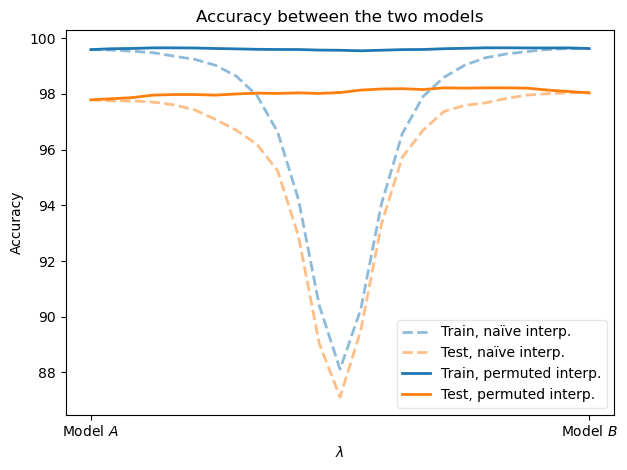

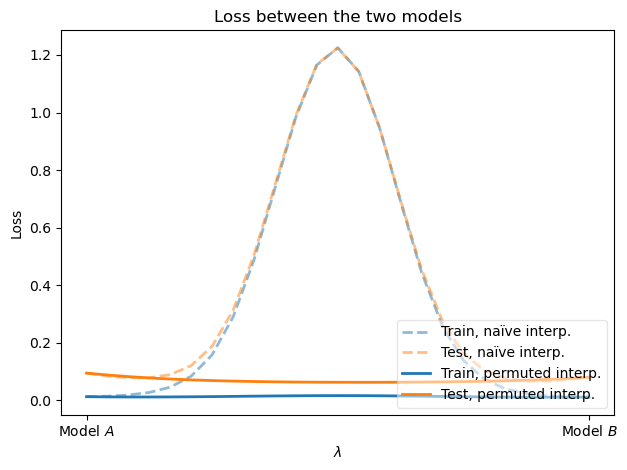

In [3]:
# Move to cpu
model_a.to("cpu")
model_b.to("cpu")

# Save old weights
model_b_old_params = copy.deepcopy(model_b.state_dict())
model_a_params = copy.deepcopy(model_a.state_dict())

# Fetch permutation spec for MLP, find best permutation, and apply it to model b 
permutation_spec = weight_matching.mlp_permutation_spec(3)
final_permutation = weight_matching.weight_matching(permutation_spec,
                                    utils.flatten_params(model_a), utils.flatten_params(model_b), verbose=0)
model_b_updated_params = weight_matching.apply_permutation(permutation_spec, final_permutation, utils.flatten_params(model_b))


# test against mnist
train_loader,test_loader = data.get_data_loaders(dataset="mnist", test_kwargs={'batch_size': 5000}, train_kwargs={'batch_size': 5000})

lambdas = torch.linspace(0, 1, steps=25)

test_acc_interp_clever = []
test_acc_interp_naive = []
train_acc_interp_clever = []
train_acc_interp_naive = []

test_loss_interp_clever = []
test_loss_interp_naive = []
train_loss_interp_clever = []
train_loss_interp_naive = []

# naive
model_b.load_state_dict(model_b_old_params)
for lam in tqdm(lambdas):
  naive_lerp_params = utils.lerp(lam, model_a_params, model_b_old_params)
  model_b.load_state_dict(naive_lerp_params)
  test_loss, acc = training.test(model_b.to(device), device, test_loader, verbose=0)
  test_acc_interp_naive.append(acc)
  test_loss_interp_naive.append(test_loss)
  train_loss, acc = training.test(model_b.to(device), device, train_loader, verbose=0)
  train_acc_interp_naive.append(acc)
  train_loss_interp_naive.append(train_loss)

# smart
model_b.load_state_dict(model_b_updated_params)
for lam in tqdm(lambdas):
  permuted_lerp_parmas = utils.lerp(lam, model_a_params, model_b_updated_params)
  model_b.load_state_dict(permuted_lerp_parmas)
  test_loss, acc = training.test(model_b.to(device), device, test_loader, verbose=0)
  test_acc_interp_clever.append(acc)
  test_loss_interp_clever.append(test_loss)
  train_loss, acc = training.test(model_b.to(device), device, train_loader, verbose=0)
  train_acc_interp_clever.append(acc)
  train_loss_interp_clever.append(train_loss)

fig = plot.plot_interp_acc(lambdas, train_acc_interp_naive, test_acc_interp_naive,
                train_acc_interp_clever, test_acc_interp_clever)
fig = plot.plot_interp_metric("loss", lambdas, train_loss_interp_naive, test_loss_interp_naive,
                train_loss_interp_clever, test_loss_interp_clever)


# Plotting A, B, and perm(B) on a contour plot

In [6]:
v1, v2, v3 = (
    utils.state_dict_to_numpy_array(model_a_params),
    utils.state_dict_to_numpy_array(model_b_old_params),
    utils.state_dict_to_numpy_array(model_b_updated_params),
)
plane = utils.generate_orthogonal_basis(v1, v2, v3)

(
    t1s,
    t2s,
    test_acc_grid,
    test_loss_grid,
    train_acc_grid,
    train_loss_grid,
) = utils.generate_loss_landscape_contour(
    model_a, device, train_loader, test_loader, plane, granularity=10
)


0it [00:00, ?it/s]/Users/tlong/Documents/code/mode_connectivity/models/mlp.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)
5it [02:37, 31.33s/it]ERROR: Unexpected segmentation fault encountered in worker.
11it [05:45, 31.42s/it]


In [9]:
from matplotlib import markers
for ((model_name, (x, y)), marker) in zip(model_vectors.items(), markers.MarkerStyle.markers.keys()):
    break

In [19]:
def plot_metric_contour(metric_name, t1s, t2s, metric_grid, model_vectors_dict):
    "Generate a contour plot of the loss landscape, along with points at x,y coordinates corresponding to models in model_vectors."
    fig = plt.figure(figsize = (6,5),dpi=100)
    fig.patch.set_facecolor('white')
    plt.title(f"{metric_name.title()} weight space cut")

    plt.contourf(t1s,t2s,metric_grid.T,cmap=plt.cm.viridis, levels=40)
    plt.colorbar()

    for ((model_name, (x, y)), marker) in zip(model_vectors_dict.items(), markers.MarkerStyle.markers.keys()):
        plt.scatter([x],[y], marker=marker, label=model_name,s=150)

    plt.xlabel("Weight direction 1",fontsize = 16)
    plt.ylabel("Weight direction 2",fontsize = 16)
    plt.legend(fontsize=10,ncol=1)
    plt.show()

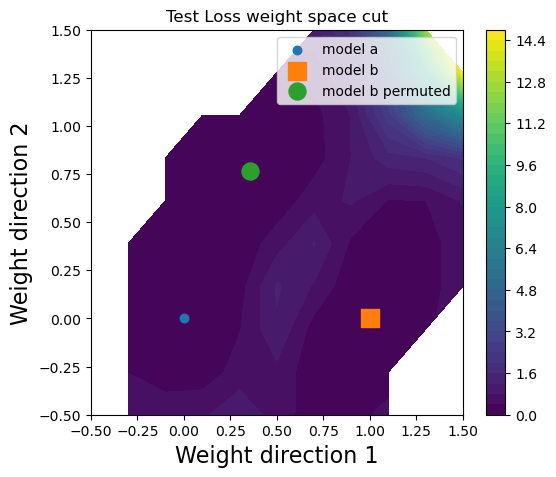

In [20]:
model_vectors = {
    "model a": utils.projection(v1, plane),
    "model b": utils.projection(v2, plane),
    "model b permuted": utils.projection(v3, plane),
}
plot_metric_contour("test loss", t1s, t2s, test_loss_grid, model_vectors)

In [4]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = torch.Tensor(data_now)
    i = i + size_now
  return output

cut_str = "Model 1 - Model 2 - (Model 2 + permutations)"

keys = model_a_params.keys()

v1 = np.concatenate([model_a_params[key].reshape([-1]) for key in keys],axis=0)
v2 = np.concatenate([model_b_old_params[key].reshape([-1]) for key in keys],axis=0)
v3 = np.concatenate([model_b_updated_params[key].reshape([-1]) for key in keys],axis=0)

basis1 = v2-v1
basis1_normed = basis1 / np.sqrt(np.sum(basis1**2.0))
basis2 = v3 - v1
basis2 = basis2 - np.sum(basis2*basis1_normed)*basis1_normed #orthogonalization
basis2_normed = basis2 / np.sqrt(np.sum(basis2**2.0))

scale = np.sqrt(np.sum(basis1**2))

t1s = np.linspace(-0.5,1.5,21)
t2s = np.linspace(-0.5,1.5,20)

test_acc_grid = np.zeros((len(t1s),len(t2s)))
test_loss_grid = np.zeros((len(t1s),len(t2s)))
train_acc_grid = np.zeros((len(t1s),len(t2s)))
train_loss_grid = np.zeros((len(t1s),len(t2s)))

for i1,t1 in tqdm(enumerate(t1s)):
  for i2,t2 in enumerate(t2s):

    new_flat_v = v1 + basis1_normed*t1*scale + basis2_normed*t2*scale
    reconstructed_flat = reconstruct(new_flat_v, model_a_params, keys)
    model_b.load_state_dict(reconstructed_flat)

    model_b.eval()
    test_loss, test_acc = training.test(model_b.to(device), device, test_loader, verbose=0)
    train_loss, train_acc = training.test(model_b.to(device), device, train_loader, verbose=0)
    
    test_acc_grid[i1,i2] = test_acc
    test_loss_grid[i1,i2] = test_loss
    train_acc_grid[i1,i2] = train_acc
    train_loss_grid[i1,i2] = train_loss
  
def projection(vector):
  x = np.sum((vector - v1)*basis1_normed)/scale
  y = np.sum((vector - v1)*basis2_normed)/scale
  return x,y


21it [22:03, 63.02s/it]


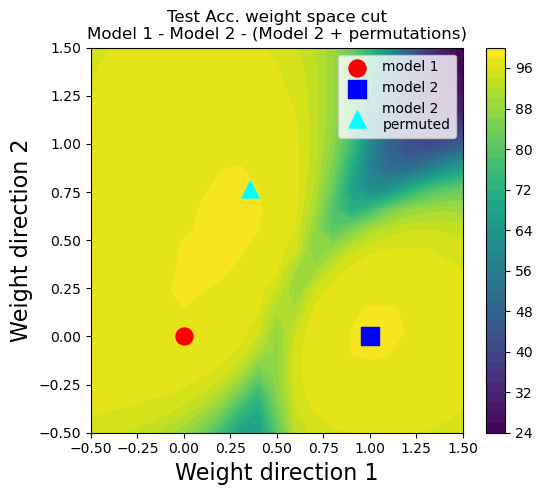

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6,5),dpi=100)
fig.patch.set_facecolor('white')
plt.title(f"Test Acc. weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,acc_grid.T,cmap=plt.cm.viridis, levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)

plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)


plt.legend(fontsize=10,ncol=1)

plt.show()

# Experiment: ResNet LMC

In [ ]:
experiment_config = experiments.RESNET_CIFAR10_DEFAULT
experiment_config.seed = 7
model_a,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval = experiments.setup_experiment(experiment_config)
experiments.run_simple_experiment(model_a,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval, verbose=1)

# Change seed to get different model
# experiment_config.seed = 42
# model_b,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval = experiments.setup_experiment(experiment_config)
# experiments.run_simple_experiment(model_b,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval, verbose=1)